In [103]:
import IPython.display as ipd
import os
import pandas as pd
import numpy as np
import librosa
import glob 
import librosa.display
import random
import matplotlib.pyplot as plt
import warnings

from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import backend as K

from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf

In [2]:
#pip install Keras
warnings.filterwarnings('ignore')

In [94]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [4]:
def extract_features(files):
    
    # Абсолютный путь файла из папки со всеми данными
    file_name = os.path.join(os.path.abspath('voice')+'/'+str(files.file))

    # возвращает звуковой временной ряд в качестве массива numpy 
    # с частотой дискретизации по умолчанию 22 кГц
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 

    # Генерация Мел-частотных кепстральных коэффициентов 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)

    # Используя короткое преобразование Фурье (STFT), вычисляем хронограмму(Цветность)
    stft = np.abs(librosa.stft(X))
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)

    # Строим мел-спектрограмму
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)

    # Вычисляем спектральный контраст
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)

    # Вычисляем тональные особенности центроида
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
        
    label = files.label

    return mfccs, chroma, mel, contrast, tonnetz, label

In [5]:
# Извлекаем список файлов
filelist = os.listdir('male') 
# Создаем датафрейм и наполняем его данными из filelist
df_male = pd.DataFrame(filelist)

In [6]:
# Добавляем метку "1" для диктора-мужчины
df_male['label']='1'

# Даем имя столбцу "file"
df_male = df_male.rename(columns={0:'file'})

In [7]:
df_male.head()

,file,label
0,1034-121119-0000.flac,1
1,1034-121119-0001.flac,1
2,1034-121119-0002.flac,1
3,1034-121119-0003.flac,1
4,1034-121119-0004.flac,1


In [8]:
# Извлекаем список файлов
filelist = os.listdir('female') 
# Создаем датафрейм и наполняем его данными из filelist
df_female = pd.DataFrame(filelist)

In [9]:
# Добавляем метку "0" для диктора-женщины
df_female['label']='0'

# Даем имя столбцу "file"
df_female = df_female.rename(columns={0:'file'})

In [10]:
df_female.head()

,file,label
0,103-1240-0000.flac,0
1,103-1240-0001.flac,0
2,103-1240-0002.flac,0
3,103-1240-0003.flac,0
4,103-1240-0004.flac,0


In [11]:
# Объединяем оба датафрема
df = pd.concat([df_female, df_male], ignore_index=True)

In [12]:
df.head()

,file,label
0,103-1240-0000.flac,0
1,103-1240-0001.flac,0
2,103-1240-0002.flac,0
3,103-1240-0003.flac,0
4,103-1240-0004.flac,0


In [13]:
df = df.sample(frac=1).reset_index(drop=True)

In [14]:
# Разделяем данные на тренировочный набор (составляет 70% от общих данных)

df_train = df[:19978]

In [15]:
df_train['label'].value_counts(normalize=True)

0    0.546852
1    0.453148
Name: label, dtype: float64

In [16]:
# Разделяем данные на проверочный набор (составляет 20% от общих данных)

df_validation = df[19978:25686]

In [17]:
df_validation['label'].value_counts(normalize=True)

0    0.532235
1    0.467765
Name: label, dtype: float64

In [18]:
# Разделяем данные на проверочный набор (составляет 10% от общих данных)

df_test = df[25686:28539]

In [19]:
df_test['label'].value_counts(normalize=True)

0    0.540834
1    0.459166
Name: label, dtype: float64

In [20]:
# Применяем функцию извлечения фичей на сырых данных из датасета
features_label = df.apply(extract_features, axis=1)

In [25]:
features_label

0        ([-358.06213, 123.3904, -13.97524, 30.738903, ...
1        ([-364.48865, 130.15599, -8.093654, 45.007336,...
2        ([-327.46094, 113.037834, -24.224415, 52.60119...
3        ([-330.9093, 104.1012, -20.743685, 26.712227, ...
4        ([-395.85446, 94.403694, -56.91725, 39.53586, ...
                               ...                        
28534    ([-368.8126, 116.6785, -11.111848, 12.109425, ...
28535    ([-363.90488, 115.366486, -19.893002, 22.27219...
28536    ([-376.32233, 71.55738, -81.27539, 53.72306, 7...
28537    ([-350.1341, 143.10709, -12.015589, 41.524525,...
28538    ([-416.84573, 101.00519, -2.9246175, 35.624912...
Length: 28539, dtype: object

In [22]:
# Сохраняем вектор извлеченных фичей

# np.save('features_label', features_label)

# Загружаем вектор извлеченных фичей

# features_label = np.load('features_label.npy', allow_pickle=True)

In [26]:
# Создаем пустой список, где объединяем все извлеченный фичи в одну.

features = []
for i in range(0, len(features_label)):
    features.append(np.concatenate((features_label[i][0], features_label[i][1], 
                features_label[i][2], features_label[i][3],
                features_label[i][4]), axis=0))

In [27]:
len(features)

28539

In [28]:
# Создаем пустой список, в который добавляем все идентификаторы дикторов, 
# зная, что id диктора определяется до первого символа "-"
speaker = []
for i in range(0, len(df)):
    speaker.append(df['file'][i].split('-')[0])

In [29]:
# Cоздаем список дикторов, наполняя его.
df['speaker'] = speaker

In [30]:
df.head()

,file,label,speaker
0,5339-14133-0039.flac,0,5339
1,831-130746-0051.flac,1,831
2,39-121914-0043.flac,0,39
3,4362-15663-0068.flac,0,4362
4,3607-29116-0023.flac,1,3607


In [31]:
# Проверяем сколько различных дикторов в датасете
df['speaker'].nunique()

251

In [32]:
# Устанавливаем метки, равные списку дикторов
labels = speaker

In [33]:
# Checking the size of labels and making sure it matches the size of features
len(labels)

28539

In [34]:
# Проверяем наличие сбалансированных классов для всех данных
np.unique(labels, return_counts=True)

(array(['103', '1034', '1040', '1069', '1081', '1088', '1098', '1116',
        '118', '1183', '1235', '1246', '125', '1263', '1334', '1355',
        '1363', '1447', '1455', '150', '1502', '1553', '1578', '1594',
        '1624', '163', '1723', '1737', '1743', '1841', '1867', '1898',
        '19', '1926', '196', '1963', '1970', '198', '1992', '200', '2002',
        '2007', '201', '2092', '211', '2136', '2159', '2182', '2196',
        '226', '2289', '229', '233', '2384', '2391', '2416', '2436', '248',
        '250', '2514', '2518', '254', '26', '2691', '27', '2764', '2817',
        '2836', '2843', '289', '2893', '2910', '2911', '2952', '298',
        '2989', '302', '307', '311', '3112', '3168', '32', '3214', '322',
        '3235', '3240', '3242', '3259', '328', '332', '3374', '3436',
        '3440', '3486', '3526', '3607', '3664', '3699', '3723', '374',
        '3807', '3830', '3857', '3879', '39', '3947', '3982', '3983', '40',
        '4014', '4018', '403', '405', '4051', '4088', '412', 

In [35]:
X = np.array(features)
y = np.array(labels)

In [36]:
lb = LabelEncoder()
y = to_categorical(lb.fit_transform(y))

In [37]:
X.shape
y.shape

(28539, 251)

In [38]:
# Выбираем тренировочный набор данных (70%)
# Выбираем проверочный набор данных (20%)
# Выбираем тестовый набор данных (10%) 

X_train = X[:19978]
y_train = y[:19978]

X_val = X[19978:25686]
y_val = y[19978:25686]

X_test = X[25686:]
y_test = y[25686:]

In [39]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

In [95]:
# Построим простую полносвязную сеть с ранней остановкой с softmax для категориальной классификации
# Мы имеем 251 класс

model = Sequential()

model.add(Dense(193, input_shape=(193,), activation = 'relu'))
model.add(Dropout(0.1))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))  

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))    

model.add(Dense(251, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m], optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [98]:
history = model.fit(X_train, y_train, batch_size=256, epochs=100, 
                    validation_data=(X_val, y_val))

Epoch 1/100
79/79 [==============================] - 2s 13ms/step - loss: 5.3625 - accuracy: 0.0251 - f1_m: 0.0021 - precision_m: 0.0810 - recall_m: 0.0011 - val_loss: 3.4309 - val_accuracy: 0.4149 - val_f1_m: 0.0510 - val_precision_m: 0.9478 - val_recall_m: 0.0263
Epoch 2/100
79/79 [==============================] - 1s 9ms/step - loss: 3.5597 - accuracy: 0.2026 - f1_m: 0.0730 - precision_m: 0.6641 - recall_m: 0.0397 - val_loss: 1.5115 - val_accuracy: 0.7779 - val_f1_m: 0.4144 - val_precision_m: 0.9815 - val_recall_m: 0.2631
Epoch 3/100
79/79 [==============================] - 1s 8ms/step - loss: 2.2208 - accuracy: 0.4359 - f1_m: 0.3165 - precision_m: 0.7693 - recall_m: 0.2014 - val_loss: 0.7282 - val_accuracy: 0.8905 - val_f1_m: 0.7780 - val_precision_m: 0.9852 - val_recall_m: 0.6434
Epoch 4/100
79/79 [==============================] - 1s 9ms/step - loss: 1.5920 - accuracy: 0.5735 - f1_m: 0.5094 - precision_m: 0.8050 - recall_m: 0.3736 - val_loss: 0.4206 - val_accuracy: 0.9322 - val_f

Epoch 32/100
79/79 [==============================] - 1s 9ms/step - loss: 0.1987 - accuracy: 0.9372 - f1_m: 0.9400 - precision_m: 0.9550 - recall_m: 0.9255 - val_loss: 0.0373 - val_accuracy: 0.9909 - val_f1_m: 0.9905 - val_precision_m: 0.9919 - val_recall_m: 0.9892
Epoch 33/100
79/79 [==============================] - 1s 9ms/step - loss: 0.1766 - accuracy: 0.9445 - f1_m: 0.9456 - precision_m: 0.9583 - recall_m: 0.9333 - val_loss: 0.0350 - val_accuracy: 0.9905 - val_f1_m: 0.9903 - val_precision_m: 0.9909 - val_recall_m: 0.9897
Epoch 34/100
79/79 [==============================] - 1s 8ms/step - loss: 0.2077 - accuracy: 0.9372 - f1_m: 0.9390 - precision_m: 0.9521 - recall_m: 0.9262 - val_loss: 0.0357 - val_accuracy: 0.9902 - val_f1_m: 0.9902 - val_precision_m: 0.9923 - val_recall_m: 0.9881
Epoch 35/100
79/79 [==============================] - 1s 9ms/step - loss: 0.1829 - accuracy: 0.9446 - f1_m: 0.9451 - precision_m: 0.9575 - recall_m: 0.9331 - val_loss: 0.0332 - val_accuracy: 0.9904 - va

Epoch 63/100
79/79 [==============================] - 1s 9ms/step - loss: 0.1097 - accuracy: 0.9667 - f1_m: 0.9674 - precision_m: 0.9732 - recall_m: 0.9617 - val_loss: 0.0271 - val_accuracy: 0.9937 - val_f1_m: 0.9935 - val_precision_m: 0.9946 - val_recall_m: 0.9924
Epoch 64/100
79/79 [==============================] - 1s 9ms/step - loss: 0.1044 - accuracy: 0.9700 - f1_m: 0.9699 - precision_m: 0.9758 - recall_m: 0.9641 - val_loss: 0.0261 - val_accuracy: 0.9933 - val_f1_m: 0.9932 - val_precision_m: 0.9939 - val_recall_m: 0.9924
Epoch 65/100
79/79 [==============================] - 1s 9ms/step - loss: 0.0993 - accuracy: 0.9684 - f1_m: 0.9686 - precision_m: 0.9740 - recall_m: 0.9632 - val_loss: 0.0260 - val_accuracy: 0.9925 - val_f1_m: 0.9926 - val_precision_m: 0.9936 - val_recall_m: 0.9916
Epoch 66/100
79/79 [==============================] - 1s 9ms/step - loss: 0.0999 - accuracy: 0.9688 - f1_m: 0.9689 - precision_m: 0.9751 - recall_m: 0.9627 - val_loss: 0.0290 - val_accuracy: 0.9932 - va

Epoch 94/100
79/79 [==============================] - 1s 8ms/step - loss: 0.0732 - accuracy: 0.9779 - f1_m: 0.9776 - precision_m: 0.9813 - recall_m: 0.9739 - val_loss: 0.0247 - val_accuracy: 0.9942 - val_f1_m: 0.9940 - val_precision_m: 0.9947 - val_recall_m: 0.9933
Epoch 95/100
79/79 [==============================] - 1s 9ms/step - loss: 0.0886 - accuracy: 0.9739 - f1_m: 0.9740 - precision_m: 0.9777 - recall_m: 0.9703 - val_loss: 0.0254 - val_accuracy: 0.9935 - val_f1_m: 0.9929 - val_precision_m: 0.9932 - val_recall_m: 0.9926
Epoch 96/100
79/79 [==============================] - 1s 9ms/step - loss: 0.0865 - accuracy: 0.9744 - f1_m: 0.9743 - precision_m: 0.9781 - recall_m: 0.9705 - val_loss: 0.0238 - val_accuracy: 0.9951 - val_f1_m: 0.9945 - val_precision_m: 0.9957 - val_recall_m: 0.9934
Epoch 97/100
79/79 [==============================] - 1s 9ms/step - loss: 0.0735 - accuracy: 0.9775 - f1_m: 0.9776 - precision_m: 0.9808 - recall_m: 0.9744 - val_loss: 0.0234 - val_accuracy: 0.9942 - va

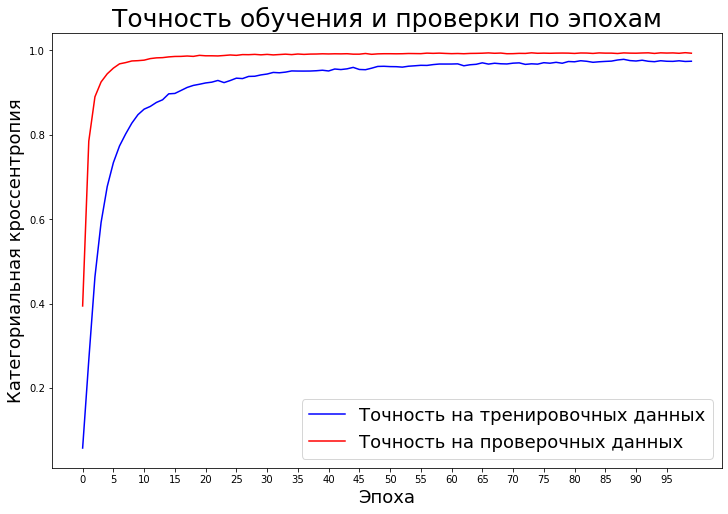

In [69]:
# Проверка точности тренировочных данных и точность проверки за эпохи.
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(12, 8))

plt.plot(train_accuracy, label='Точность на тренировочных данных', color='blue')
plt.plot(val_accuracy, label='Точность на проверочных данных', color='red')

plt.title('Точность обучения и проверки по эпохам', fontsize = 25)
plt.xlabel('Эпоха', fontsize = 18)
plt.ylabel('Категориальная кроссентропия', fontsize = 18)
plt.xticks(range(0,100,5), range(0,100,5))

plt.legend(fontsize = 18);

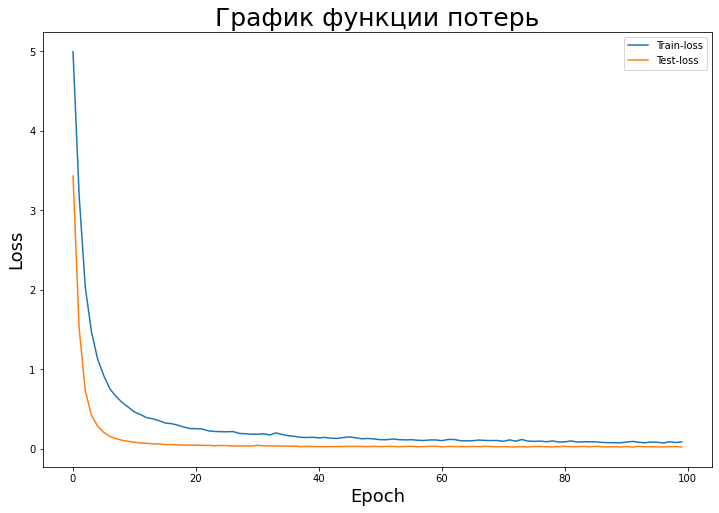

In [115]:
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График функции потерь', fontsize = 25)
plt.ylabel('Loss',fontsize = 18)
plt.xlabel('Epoch',fontsize = 18)
plt.legend(['Train-loss', 'Test-loss'])
plt.show()

In [52]:
# оцениваем модель
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=0)

In [53]:
# Получаем прогнозы на основе тестовых данных
preds = model.predict_classes(X_test)

In [54]:
# Преобразуем прогнозы обратно в идентификаторы выступающих
preds = lb.inverse_transform(preds)

In [55]:
# Разделяем датафрейм на тестовый набор данных
df_test = df[25686:]

In [56]:
# Создаем столбец "preds", и устанавливаем его равным прогнозам
df_test['preds'] = preds

In [57]:
# Проверяем прогнозы на тестовом наборе данных
df_test

,file,label,speaker,preds
25686,7148-59157-0025.flac,0,7148,7148
25687,625-132112-0007.flac,1,625,625
25688,6181-216552-0041.flac,1,6181,6181
25689,3699-19402-0012.flac,1,3699,3699
25690,328-129766-0063.flac,0,328,328
...,...,...,...,...
28534,8051-119902-0016.flac,0,8051,8051
28535,7800-283493-0015.flac,0,7800,7800
28536,8609-262281-0032.flac,1,8609,8609
28537,4898-28461-0057.flac,1,4898,4898


In [58]:
# Проверяем, сколько дикторов мы определили неверно.
df_test[df_test['speaker'] != df_test['preds']]

,file,label,speaker,preds
25691,1737-142397-0014.flac,0,1737,3857
25719,1898-145724-0030.flac,0,1898,289
26130,198-129977-0016.flac,0,198,839
26195,8975-270782-0108.flac,0,8975,1183
26266,4898-20016-0026.flac,1,4898,8629
26432,6454-93938-0012.flac,1,6454,6081
26486,4680-16041-0010.flac,0,4680,5867
26653,1898-145724-0017.flac,0,1898,1455
26735,8770-295463-0000.flac,1,8770,909
26848,1235-135883-0045.flac,0,1235,8629


In [59]:
# Проверка точности нашей модели
1-round(len(df_test[df_test['speaker'] != df_test['preds']])/len(df_test),3)

0.994